# Federated Averaging with the Wine Dataset

This notebook demonstrates the concept of Federated Averaging (FedAvg), a core technique in Federated Learning, using the wine dataset as an example.

**Objective:**

Imagine a scenario where several wineries want to collaborate to build a robust wine classification model.
However, each winery is hesitant to share its proprietary data with others. Federated Averaging offers a solution by enabling collaborative model training without requiring direct data sharing.

In this example, we'll simulate a simplified Federated Learning environment where:

* Each winery predominantly cultivates one specific wine grape variety (~95%). To account for occasional variations, each winery also cultivates smaller amounts of other grape varieties (~2.5% for both remaining varieties).
* Wineries train local models on their individual datasets.
* A central server aggregates the local model parameters to create a global model.

**Let's get started!**

First, let's load the wine dataset and explore its structure.

In [1]:
#Imports
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the wine dataset into a DataFrame
wine = load_wine(as_frame=True)
df = wine.frame

df.sample(frac=1).head() #sample shuffles the dataset

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
73,12.99,1.67,2.60,30.0,139.0,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985.0,1
85,12.67,0.98,2.24,18.0,99.0,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450.0,1
133,12.70,3.55,2.36,21.5,106.0,1.70,1.20,0.17,0.84,5.00,0.78,1.29,600.0,2
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0,0


To simulate a federated learning scenario with three wineries, we first split the wine dataset into a training set and a test set. We use 70% of the data for training and reserve the remaining 30% for evaluating the final global model. This initial split ensures that we have unseen data to assess the generalization performance of our collaboratively trained model.

Next, we divide the training data among the three wineries, aiming for a distribution where each winery predominantly holds data for one specific wine class. We begin by sampling 70% of the data points belonging to each class to form the core of each winery's dataset.

To introduce some diversity and reflect real-world scenarios where wineries might cultivate smaller amounts of other grape varieties, we distribute the remaining training data among the wineries. Each winery receives a portion of the data points belonging to the other two classes, ensuring that all training data is utilized.

This process results in three datasets, one for each winery, with an approximate distribution of 95% for the predominant class and 2.5% for each of the other two classes. This setup mimics a scenario where wineries have specialized expertise in one type of wine but also possess knowledge of other varieties.

In [3]:
# Split the dataset in training and test set
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['target'])

# Split the dataset into three parts, one for each wine class
df_0 = df_train[df_train['target'] == 0].sample(frac=0.95)
df_1 = df_train[df_train['target'] == 1].sample(frac=0.95)
df_2 = df_train[df_train['target'] == 2].sample(frac=0.95)

df_remaining = df_train.drop(df_0.index).drop(df_1.index).drop(df_2.index)

df_0 = pd.concat([
    df_0,
    df_remaining[df_remaining['target'] == 1].sample(frac=0.5),
    df_remaining[df_remaining['target'] == 2].sample(frac=0.5)
])

df_1 = pd.concat([
    df_1,
    df_remaining[df_remaining['target'] == 0].sample(frac=0.5),
    df_remaining[df_remaining['target'] == 2].sample(frac=0.5)
])

df_2 = pd.concat([
    df_2,
    df_remaining[df_remaining['target'] == 0].sample(frac=0.5),
    df_remaining[df_remaining['target'] == 1].sample(frac=0.5)
])

# Display the data distribution for each winery with total counts
for i, df_winery in enumerate([df_0, df_1, df_2]):
    print(f"\nData distribution for Winery {i}:")
    value_counts = df_winery['target'].value_counts()
    total_count = len(df_winery)
    print(f"Total samples: {total_count}")
    print(value_counts / total_count)  # Display percentages
    print(value_counts)  # Display raw counts


Data distribution for Winery 0:
Total samples: 41
target
0    0.95122
1    0.02439
2    0.02439
Name: count, dtype: float64
target
0    39
1     1
2     1
Name: count, dtype: int64

Data distribution for Winery 1:
Total samples: 50
target
1    0.96
0    0.02
2    0.02
Name: count, dtype: float64
target
1    48
0     1
2     1
Name: count, dtype: int64

Data distribution for Winery 2:
Total samples: 33
target
2    0.939394
0    0.030303
1    0.030303
Name: count, dtype: float64
target
2    31
0     1
1     1
Name: count, dtype: int64


Now that we have prepared the datasets for each winery, let's train individual machine learning models on their respective data. For this example, we'll use a simple Logistic Regression model. Logistic Regression is a widely used classification algorithm that is well-suited for this type of problem.

We will train one Logistic Regression model for each winery using its own dataset. This will allow us to simulate the local training that occurs in a federated learning environment. After training the models, we'll examine the learned weights (coefficients) of each model to understand how they are capturing the unique characteristics of each winery's data.

In [4]:
models = {}
for i, df_winery in enumerate([df_0, df_1, df_2]):
    X_train = df_winery.drop('target', axis=1)
    y_train = df_winery['target']
    model = LogisticRegression(max_iter=100000) #In this case, the max_iter is not important. Setting at high value to keep the output clean
    model.fit(X_train, y_train)
    models[f"winery_{i}"] = model

    # Print the model's coefficients (weights)
    print(f"\nModel for Winery {i} - Coefficients:")
    for j, coef in enumerate(model.coef_):
        print(f"  Class {j}: {coef}")


Model for Winery 0 - Coefficients:
  Class 0: [3.13438605e-03 5.33489400e-04 5.12167368e-04 4.26261125e-03
 2.38571740e-02 5.31387900e-04 4.82326054e-04 8.31659986e-05
 3.71882779e-04 1.35390489e-03 2.20742407e-04 6.60455438e-04
 1.59893630e-01]
  Class 1: [-0.03375616 -0.08758937 -0.00878089 -0.07421452 -0.25183403  0.02368507
  0.04304901 -0.00683944 -0.00270237 -0.05243392  0.00973975  0.04899075
 -0.11470559]
  Class 2: [ 0.03062177  0.08705588  0.00826873  0.06995191  0.22797685 -0.02421646
 -0.04353133  0.00675627  0.00233049  0.05108002 -0.00996049 -0.04965121
 -0.04518804]

Model for Winery 1 - Coefficients:
  Class 0: [-0.02204302 -0.00289891 -0.00480091 -0.06021707 -0.14921097 -0.00334776
 -0.00055732 -0.00136316  0.00114051  0.00487594 -0.00203162 -0.00540208
  0.01851096]
  Class 1: [-0.23307067  0.09394231 -0.06500765  0.05861599  0.02819595  0.19845983
  0.15074233  0.04988317  0.40345383 -0.46030223  0.17161274  0.53715898
 -0.00720831]
  Class 2: [ 0.25511369 -0.091043

Before we proceed with federated averaging, let's evaluate the performance of each individual model on the test set. This will give us a baseline to compare against the performance of the global model that we will obtain through federated averaging.

We expect that the individual models will have relatively low accuracy on the test set. This is because each model is trained on a limited dataset that predominantly represents one specific wine class. Consequently, the models might struggle to generalize well to unseen data that contains a more balanced distribution of classes.

In [5]:
# Evaluate the accuracy of each model on the test set
for i, df_winery in enumerate([df_0, df_1, df_2]):
    X_test = df_test.drop('target', axis=1)
    y_test = df_test['target']
    y_pred = models[f"winery_{i}"].predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nWinery {i} - Accuracy: {accuracy:.4f}")


Winery 0 - Accuracy: 0.6481

Winery 1 - Accuracy: 0.7037

Winery 2 - Accuracy: 0.4630


As you can see (and if you were not lucky), the accuracies are quite unbalanced and low. However, accuracy is not enough to understand the challenge that FL solves. To really understand it, let's look at the confusion matrices.

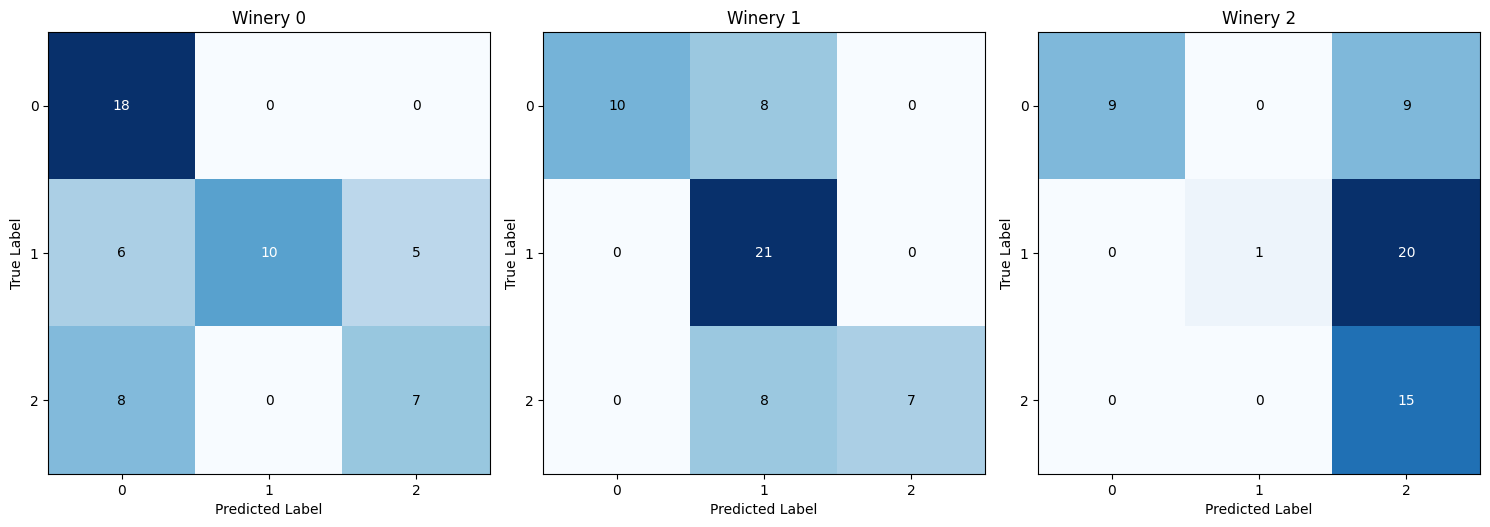

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, df_winery in enumerate([df_0, df_1, df_2]):
    X_test = df_test.drop('target', axis=1)
    y_test = df_test['target']
    y_pred = models[f"winery_{i}"].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i].set_title(f'Winery {i}')
    axes[i].set_xticks([0, 1, 2])
    axes[i].set_yticks([0, 1, 2])
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

    # Add text annotations
    thresh = cm.max() / 2.
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            axes[i].text(k, j, format(cm[j, k], 'd'),
                         ha="center", va="center",
                         color="white" if cm[j, k] > thresh else "black")

plt.tight_layout()
plt.show()

As we've seen, individual models trained on isolated datasets have limitations. This is where **federated averaging (FedAvg)** comes in. FedAvg is a core technique in federated learning that enables collaborative model training without directly sharing data.

Here's how it works:

1. **Local Training:** Each client (winery in our case) trains a model on its local data.
2. **Parameter Sharing:** Clients send their model's parameters (weights and biases) to a central server.
3. **Aggregation:** The server aggregates these parameters, typically by averaging them, to create a global model.
4. **Distribution:** The server sends the updated global model back to the clients.
5. **Iteration:** Clients update their local models with the global model and repeat the process.

This iterative process allows the global model to learn from the diverse data held by each client without compromising privacy.




Global Model - Accuracy: 0.7037


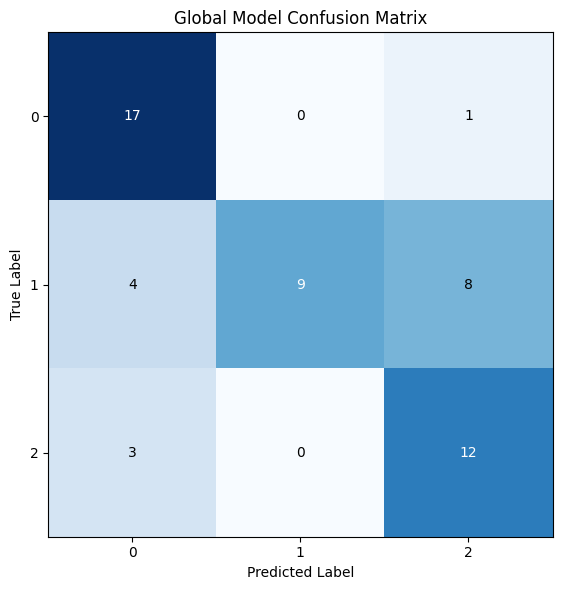

In [7]:
# Average the weights of the models
global_coef = np.mean([models[f"winery_{i}"].coef_ for i in range(3)], axis=0)
global_intercept = np.mean([models[f"winery_{i}"].intercept_ for i in range(3)], axis=0)

# Create a new model with the averaged weights
global_model = LogisticRegression()
global_model.coef_ = global_coef
global_model.intercept_ = global_intercept

# Manually set the classes_ attribute (important!)
global_model.classes_ = models["winery_0"].classes_ 

# Evaluate the global model on the test set
X_test = df_test.drop('target', axis=1).values
y_test = df_test['target']
y_pred_global = global_model.predict(X_test)
accuracy_global = accuracy_score(y_test, y_pred_global)
print(f"\nGlobal Model - Accuracy: {accuracy_global:.4f}")

# Confusion matrix for the global model
cm_global = confusion_matrix(y_test, y_pred_global)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_global, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Global Model Confusion Matrix')
plt.xticks([0, 1, 2])
plt.yticks([0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm_global.max() / 2.
for i in range(cm_global.shape[0]):
    for j in range(cm_global.shape[1]):
        plt.text(j, i, format(cm_global[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_global[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated the concept of Federated Averaging using a simplified simulation of wineries collaborating to build a wine classification model. We observed the following:

* **Limited Local Performance:** Individual models trained on isolated, class-specific datasets struggled to generalize to unseen data with a balanced class distribution.
* **Improved Global Performance:** Federated Averaging enabled the creation of a global model that achieved higher accuracy and a more balanced performance across all classes by combining the knowledge from individual models.
* **Data Privacy:** The collaborative training process occurred without wineries sharing their raw data, highlighting the privacy-preserving nature of federated learning.

**Important Note:** This simulation does not use a fixed random seed for data splitting. This means that the results might vary each time you run the notebook. In some cases, the individual models might achieve unexpectedly high accuracy due to the random distribution of data. If you encounter such a scenario, simply re-run the notebook a few times to observe the more typical behavior where federated averaging significantly improves performance.

Also, keep in mind that this is a simplified example of federated learning. In real-world applications, federated learning is usually performed in multiple rounds, where clients iteratively train their local models and the server aggregates the parameters over several iterations. This iterative process allows for gradual refinement and improvement of the global model.

This simplified example provides a foundation for understanding the potential of federated learning in real-world scenarios where data privacy and collaboration are crucial.